In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

import inputools.Trajectory as it
from tools.evolutions import load_best_individual
import src.models as mm
from src.models import logger
import src.visualizations as mv

from tools.utils import clf

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger()

2024-01-18 13:41:49 | 


## Input space

In [530]:
pcs = np.array([[0.25, 0.25], [0.75, 0.25], [0.5, 0.75]])
gauss = lambda x, tu, s: np.exp(-np.linalg.norm(
    x.reshape(-1, 2) - tu.reshape(-1, 1, 2), axis=2)**2 / s)
pcs_x = lambda x, w: gauss(x, pcs, 0.04) * w

space_box = it.make_whole_walk(dx=0.01)
space_pc = pcs_x(space_box, 1)
space_box.shape

(10201, 2)

In [531]:
space_box.shape

(10201, 2)

In [357]:
k = 8 * 19
print(space_pc[:, k:k+10], '\n')
print(np.exp(-(space_pc[:, k:k+10] - np.array([0.4, 0.05]).reshape(2, 1))**2))

[[0.63762815 0.60653066 0.52204578 0.40656966 0.2865048  0.18268352
  0.10539922 0.05502322 0.02599113 0.011109  ]
 [0.0042963  0.011109   0.02599113 0.05502322 0.10539922 0.18268352
  0.2865048  0.40656966 0.52204578 0.60653066]] 

[[0.94509754 0.95824201 0.98521521 0.99995684 0.98720145 0.95387137
  0.91686997 0.88779983 0.86946027 0.85964462]
 [0.99791335 0.99848863 0.99942374 0.99997477 0.99693563 0.98254914
  0.94560105 0.88060869 0.80025311 0.73364767]]


In [458]:
space_pc.shape

(3, 10201)

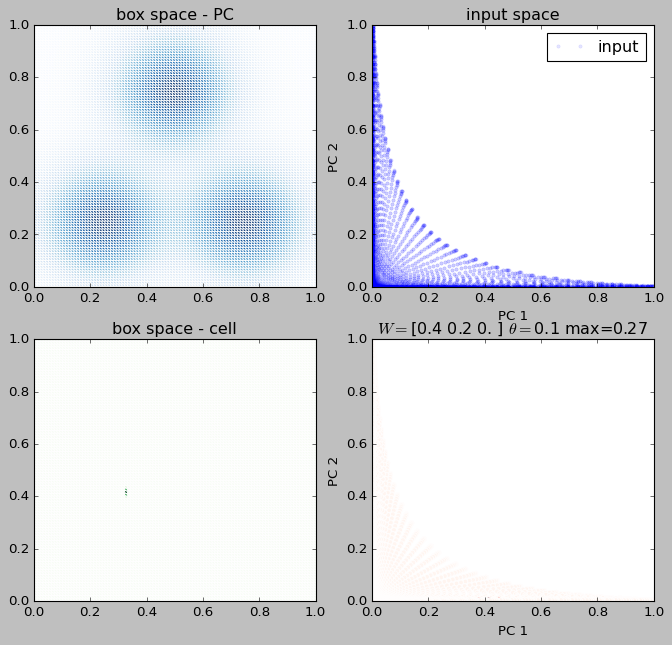

In [479]:
w = np.array([[0.4], [0.2], [0.]])
thr = 0.1
#cell_x = lambda x, thr: 1 / (1 + np.exp(-10*(x.sum(axis=0)-thr)))
#cell_x = lambda x, thr: 1 / (1 + np.exp(-6*(x.sum(axis=0)-thr)))
cell_x = lambda x, thr: 1 / (1 + np.exp(-10*(x-thr)))
#cell_x = lambda x, thr: 1*(x.sum(axis=0)>thr)

ds1 = space_pc.sum(axis=0)

space_pc_w = pcs_x(space_box, w)
#activation = cell_x(space_pc_w.sum(axis=0), thr)
activation = cell_x(np.exp(-np.linalg.norm(
    space_pc.reshape(-1, 3) - w.reshape(-1, 1, 3), axis=2) / 0.01).sum(axis=0),
                    thr)
#activation = cell_x(np.exp(-(space_pc - w)**2).prod(axis=0), thr)
#activation = cell_x(space_pc.T @ w, thr)

#activation[0] = 0.15

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9))

#
ax1.scatter(space_box[:, 0], space_box[:, 1], 
            c=space_pc.sum(axis=0), 
            cmap="Blues", edgecolors='white')

ax1.set_title("box space - PC")
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

#
ax2.plot(space_pc[0], space_pc[1], '.b', alpha=0.1, label='input')
ax2.set_title("input space")
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.legend(loc="upper right")

#
ax3.scatter(space_box[:, 0], space_box[:, 1], c=activation, 
            cmap="Greens", edgecolors='white')
#ax3.plot(activation[0], activation[1])
ax3.set_title("box space - cell")
ax3.set_xlim((0, 1))
ax3.set_ylim((0, 1))

#
#ax4.plot(activation[0], activation[1], '.r', alpha=0.01, label=f"w={w.flatten()}")
#ax4.plot(space_pc_w[0], space_pc_w[1], '.r', alpha=0.01, label=f"w={w.flatten()}")
#ax4.scatter(space_pc_w[0], space_pc_w[1], c=activation.flatten(), 
#            cmap='Greens', edgecolors='white', alpha=1.)
ax4.scatter(space_pc[0], space_pc[1], c=activation, 
            cmap='Reds', edgecolors='white', alpha=0.8)
ax4.set_title(f"$W=${w.flatten()} $\\theta=${thr} max={activation.max():.2f}")
ax4.set_xlim((0, 1))
ax4.set_ylim((0, 1))
ax4.set_xlabel("PC 1")
ax4.set_ylabel("PC 2")
#ax4.legend(loc="upper right")

plt.show()


## Hebbian

In [577]:
class Node:
    def __init__(self, Nj=3, lr=1e-2, u=0., noise=None):
        self.Nj = Nj
        self.w = np.zeros((1, Nj))
        self.lr = lr
        self.u = u
        self.a = 0.
        if not noise:
            self.noise = lambda: 0 
        else:
            self.noise = noise 
    
    def __call__(self, x, update=True, isnoise=True):
        self.u = self.w @ x + self.noise() * int(isnoise)
        self.a = 1 / (1 + np.exp(-20*(self.u - 1)))
        if update:
            self.w += self.lr * (self.a @ x.T - 0.3*self.w @ (x*x.T))

    def plotw(self, t, tper=10):
        if t % tper == 0:
            clf()
            plt.plot(range(self.Nj), self.w.flatten())
            plt.title(f"{t=} - {np.around(self.w.flatten(), 2)}")
            plt.ylim((0, 3))
            plt.grid()
            plt.pause(0.01)

def sample_is(model):
    """ visualized the model response in the input space """
    I = it.make_whole_walk(dx=0.01)
    A = np.zeros(len(I))
    for j, x in enumerate(I):
        model(x=x.reshape(-1, 1), update=False, isnoise=False)
        A[j] = model.a.item()

    plt.scatter(I[:, 0], I[:, 1], 
            c=A, cmap="Blues", edgecolors='white')
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

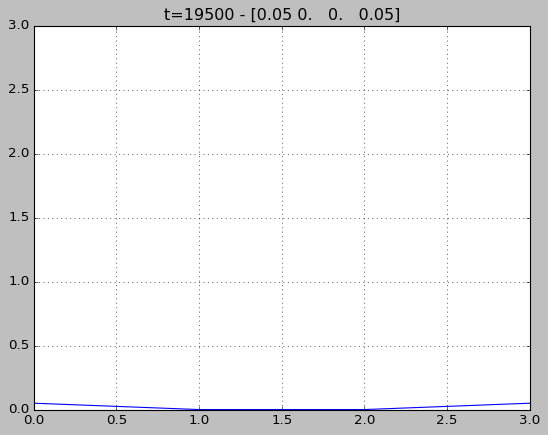

2024-01-16 17:33:37 | 


In [578]:
Nj = 4
T = 20*1000
I = np.zeros((Nj, T))
I[0] = 1
I[Nj-1] = 1.

node = Node(Nj=Nj, lr=0.01, u=0.01, noise=lambda: np.random.binomial(1, 0.05))

for t in range(T):
    node(x=I[:, t].reshape(-1, 1))
    node.plotw(t=t, tper=500)
        

logger()

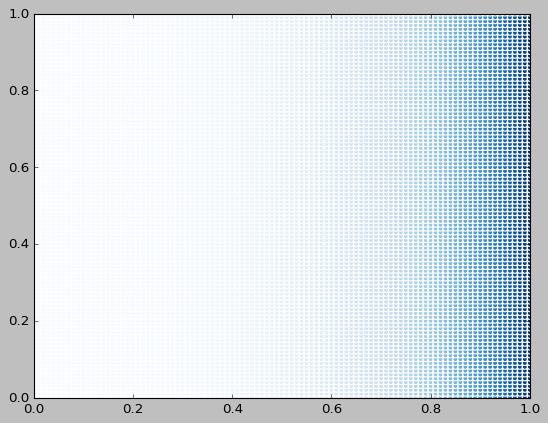

In [571]:
sample_is(node)

## Input II

In [611]:
def make_input(Nj, T, Np=1):
    """ 
    make an input with Nj channels making up Np inputs 

    Returns
    -------
    shape: (T, Nj)
    """
    assert T % Np == 0, "make sure that Np divides T"
    x = np.zeros((T, Nj))
    patterns = [np.random.binomial(1, 0.3, Nj)*np.random.uniform(0, 1, Nj) for _ in range(Np)]
    size = T // Np
    for i, t in enumerate(range(0, T, size)):
        x[t:t+size] = patterns[i]
    return x

make_input(Nj=5, T=12, Np=3)

array([[0.        , 0.        , 0.58830515, 0.        , 0.87475036],
       [0.        , 0.        , 0.58830515, 0.        , 0.87475036],
       [0.        , 0.        , 0.58830515, 0.        , 0.87475036],
       [0.        , 0.        , 0.58830515, 0.        , 0.87475036],
       [0.50522026, 0.        , 0.        , 0.        , 0.27681841],
       [0.50522026, 0.        , 0.        , 0.        , 0.27681841],
       [0.50522026, 0.        , 0.        , 0.        , 0.27681841],
       [0.50522026, 0.        , 0.        , 0.        , 0.27681841],
       [0.        , 0.39284075, 0.        , 0.        , 0.        ],
       [0.        , 0.39284075, 0.        , 0.        , 0.        ],
       [0.        , 0.39284075, 0.        , 0.        , 0.        ],
       [0.        , 0.39284075, 0.        , 0.        , 0.        ]])

In [4]:
help(it.make_patterned_input)

Help on function make_patterned_input in module inputools.Trajectory:

make_patterned_input(N: int, T: int, Np: int = 1, **kwargs) -> numpy.ndarray
    make an input with N channels making up Np patterns 
    
    Parameters
    ----------
    N : int
        number of channels
    T : int
        number of time steps
    Np : int
        number of patterns. Default: 1
    **kwargs : dict
        p : float
            probability of a channel being active. Default: 0.3
        binary : bool
            whether to make a binary input or not. Default: False
        cycles : int
            number of cycles of the series of pattern. Default: 1
    
    Returns
    -------
    input: np.ndarray
        shape (T, N)



In [56]:
it.make_patterned_input(N=5, T=30, Np=3, cycles=1, binary=True, size=2, seed=1)


array([[0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0.]])

##### from evolution

In [693]:
record = load_best_individual()
genome = record['genome']
pprint(record)

2024-01-16 19:43:18 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2024-01-16 19:43:18 | 0: best_16_pcnn_d.json
2024-01-16 19:43:18 | 1: best_24_pcnn_d.json
2024-01-16 19:43:18 | 2: top_2311.json
2024-01-16 19:43:18 | 3: best_14_pcnn.json
2024-01-16 19:43:18 | 4: best_20.json
2024-01-16 19:43:18 | 5: best_12_pcnn.json
2024-01-16 19:43:18 | 6: best_28_pcnn_d.json
2024-01-16 19:43:18 | 7: top_2238.json
2024-01-16 19:43:18 | 8: best_21_pcnn_d.json
2024-01-16 19:43:18 | 9: best_29_pcnn_ptt.json
2024-01-16 19:43:18 | 10: best_8.json
2024-01-16 19:43:18 | 11: best_22_pcnn_d.json
2024-01-16 19:43:18 | 12: best_15_pcnn.json
2024-01-16 19:43:18 | 13: best_30_pcnn_ptt.json
2024-01-16 19:43:18 | 14: best_10.json
2024-01-16 19:43:18 | 15: best_19_pcnn_d.json
2024-01-16 19:43:18 | 16: best_13_pcnn.json
2024-01-16 19:43:18 | 17: best_11.json
2024-01-16 19:43:18 | 18: top_ij_1.json
2024-01-16 19:43:18 | 19: best_27_pcnn_d.json
2024-01-16 19:43:18 | 20: best_9.json
2024-01-16 19:43:18 |

Select a file index:  13


2024-01-16 19:43:26 | loaded `best_30_pcnn_ptt.json` from `/Users/daniekru/Research/lab/PCNN/cache`


{'genome': {'DA_tau': 3,
            'IS_magnitude': 14.4,
            'N': 5,
            'Nj': 5,
            'bias': 4.7,
            'bias_decay': 100,
            'bias_scale': 0.0,
            'dt': 1,
            'gain': 7.0,
            'is_retuning': False,
            'lr': 0.58848,
            'nb_per_cycle': 8,
            'nb_skip': 2,
            'plastic': True,
            'soft_beta': 3.0,
            'std_tuning': 0.0,
            'tau': 7,
            'theta_freq': 0.004,
            'theta_freq_increase': 0.05279027898008469,
            'wff_max': 4.0,
            'wff_min': 0.0,
            'wff_std': 0.0,
            'wff_tau': 450},
 'info': {'data': {'Np': 0.6, 'cycles': 2, 'dt': 0.001, 'duration': 40},
          'date': '16/01/2024 at 19:28',
          'evolved': ['bias',
                      'lr',
                      'tau',
                      'wff_max',
                      'wff_tau',
                      'soft_beta',
                      'IS_magnitu

#### run

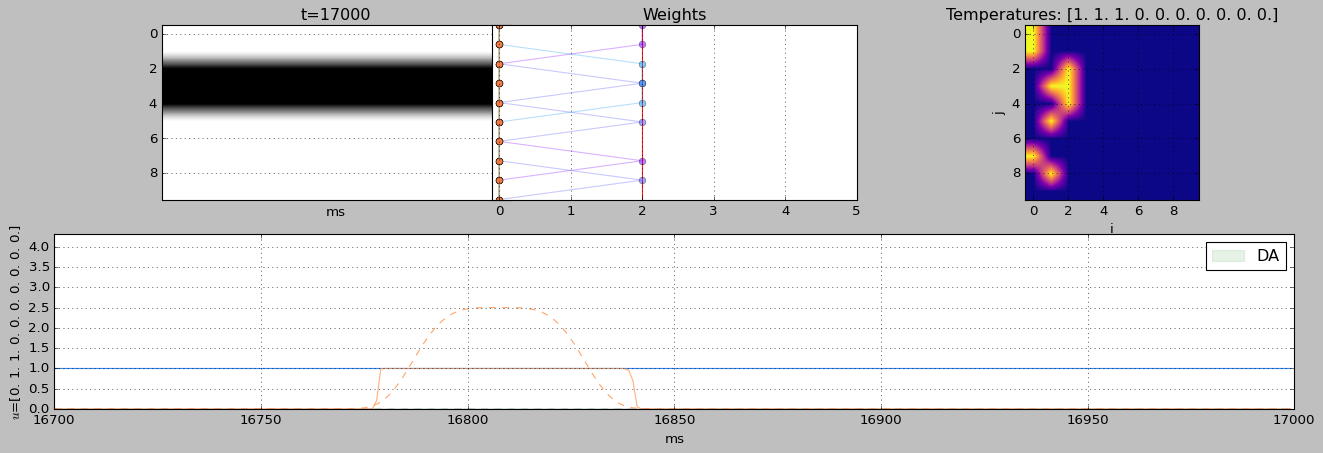

2024-01-18 14:14:52 | 


In [57]:
seed = None

genome = {
          'gain': 10.0,
          'bias': 1.1,
          'lr': 0.4,
          'tau': 700,
          'wff_std': 0.0,
          'wff_min': 0.0,
          'wff_max': 2.,
          'wff_tau': 5_000,
          'soft_beta': 2,
          'dt': 1,
          'N': 5,
          'Nj': 5,
          'DA_tau': 3,
          'bias_scale': 0.0,
          'bias_decay': 100,
          'IS_magnitude': 20,
          'theta_freq': 0.002,
          'nb_per_cycle': 5,
          'plastic': True,
          'nb_skip': 2,
          'seed': seed,
}

""" Initialization """

N, Nj = 10, 10
genome['N'] = N
genome['Nj'] = Nj
model = mm.PCNNetwork(**genome)

# select
inputs = it.make_patterned_input(N=Nj, T=18*1000, Np=3, cycles=1, binary=True, size=3, seed=seed)

""" Run """

record = np.zeros((N+1, len(inputs)))
Ix = np.zeros((N, len(inputs)))
X2 = np.zeros((len(inputs) + 10, Nj))
colors = [plt.cm.rainbow(i/N) for i in range(N)]

for t, x in enumerate(inputs):
  
    model.step(x=x.reshape(-1, 1))
    record[1:, t] = model.u.flatten()
    record[0, t] = model.DA
    Ix[:, t] = model.Is.flatten() / 8
    
    X2[10:t+10] = inputs[:t]

    if t % 1000 == 0:
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors, subtitle_2=np.around(model.var1, 2))            
    
logger()

In [53]:
np.around(model.W_deriv, 5)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])